In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

In [2]:
plt.rcParams["figure.dpi"] = 120

In [3]:
data_dir = "../data"

In [4]:
label_map = {
    "medical": "Medical",
    "Medicine": "Medicine",
}

In [5]:
# FineFineWeb, Identity Counterfactual
dataset = "finefineweb"
experiment = "identity_counterfactual"

dfs_raw = [
    (
        "II Medical",
        "medical",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2875_ii-medical_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2876_qwen2.5-7b-instruct_4bit_rephrase_finefineweb.pkl"),
    ),
    (
        "MedReason",
        "medical",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2877_medreason_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2878_huatougpt_4bit_rephrase_finefineweb.pkl"),
    ),
    (
        "Llama 2 Medicine",
        "medical",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2941_medicine-chat_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2942_llama-2-chat_4bit_rephrase_finefineweb.pkl"),
    ),
    (
        "Medicine Llama 3",
        "medical",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2939_medicine-llama-3-8b_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2940_llama-3-8b_4bit_rephrase_finefineweb.pkl"),
    ),
]

In [179]:
# FineFineWeb, Rephrase Counterfactual
dataset = "finefineweb"
experiment = "rephrased_counterfactual"

dfs_raw = [
    (
        "II Medical",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2875_ii-medical_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2876_qwen2.5-7b-instruct_4bit_rephrase_finefineweb.pkl"),
    ),
    (
        "MedReason",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2877_medreason_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2878_huatougpt_4bit_rephrase_finefineweb.pkl"),
    ),
    (
        "Llama 2 Medicine",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2941_medicine-chat_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2942_llama-2-chat_4bit_rephrase_finefineweb.pkl"),
    ),
    (
        "Medicine Llama 3",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2939_medicine-llama-3-8b_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2940_llama-3-8b_4bit_rephrase_finefineweb.pkl"),
    ),
]

In [187]:
# FineFineWeb, Synonym Counterfactual
dataset = "finefineweb"
experiment = "synonym_counterfactual"

dfs_raw = [
    (
        "II Medical",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3104_ii-medical_4bit_synonym_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3105_qwen2.5-7b-instruct_4bit_synonym_finefineweb.pkl"),
    ),
    (
        "MedReason",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3066_medreason_4bit_synonym_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3067_huatougpt_4bit_synonym_finefineweb.pkl"),
    ),
    (
        "Llama 2 Medicine",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3005_medicine-chat_4bit_synonym_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3006_llama-2-chat_4bit_synonym_finefineweb.pkl"),
    ),
    (
        "Medicine Llama 3",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3003_medicine-llama-3-8b_4bit_synonym_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3004_llama-3-8b_4bit_synonym_finefineweb.pkl"),
    ),
]

In [203]:
# FineFineWeb, Random Counterfactual
dataset = "finefineweb"
experiment = "random_counterfactual"

dfs_raw = [
    (
        "II Medical",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3068_ii-medical_4bit_random_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3069_qwen2.5-7b-instruct_4bit_random_finefineweb.pkl"),
    ),
    (
        "MedReason",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3070_medreason_4bit_random_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3071_huatougpt_4bit_random_finefineweb.pkl"),
    ),
    (
        "Llama 2 Medicine",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3022_medicine-chat_4bit_random_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3023_llama-2-chat_4bit_random_finefineweb.pkl"),
    ),
    (
        "Medicine Llama 3",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3020_medicine-llama-3-8b_4bit_random_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3021_llama-3-8b_4bit_random_finefineweb.pkl"),
    ),
]

In [13]:
# FineFineWeb, II Medical Different Counterfactuals
dataset = "finefineweb"
experiment = "ii_medical_counterfactuals"

dfs_raw = [
    (
        "Identity",
        "medical",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2875_ii-medical_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2876_qwen2.5-7b-instruct_4bit_rephrase_finefineweb.pkl"),
    ),
    (
        "Rephrase",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2875_ii-medical_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2876_qwen2.5-7b-instruct_4bit_rephrase_finefineweb.pkl"),
    ),
    (
        "Rephrase Std",
        "medical",
        "rephrased_gradient_std",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2875_ii-medical_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2876_qwen2.5-7b-instruct_4bit_rephrase_finefineweb.pkl"),
    ),
    (
        "Synonym",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3104_ii-medical_4bit_synonym_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3105_qwen2.5-7b-instruct_4bit_synonym_finefineweb.pkl"),
    ),
    (
        "Synonym Std",
        "medical",
        "rephrased_gradient_std",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3104_ii-medical_4bit_synonym_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3105_qwen2.5-7b-instruct_4bit_synonym_finefineweb.pkl"),
    ),
    (
        "Random",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3068_ii-medical_4bit_random_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3069_qwen2.5-7b-instruct_4bit_random_finefineweb.pkl"),
    ),
    (
        "Random Std",
        "medical",
        "rephrased_gradient_std",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3068_ii-medical_4bit_random_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3069_qwen2.5-7b-instruct_4bit_random_finefineweb.pkl"),
    ),
]

In [219]:
# FineFineWeb, Medicine Llama 3 Different Counterfactuals
dataset = "finefineweb"
experiment = "medicine_llama_3_counterfactuals"

dfs_raw = [
    (
        "Identity",
        "medical",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2939_medicine-llama-3-8b_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2940_llama-3-8b_4bit_rephrase_finefineweb.pkl"),
    ),
    (
        "Rephrase",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2939_medicine-llama-3-8b_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2940_llama-3-8b_4bit_rephrase_finefineweb.pkl"),
    ),
    (
        "Rephrase Std",
        "medical",
        "rephrased_gradient_std",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2939_medicine-llama-3-8b_4bit_rephrase_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2940_llama-3-8b_4bit_rephrase_finefineweb.pkl"),
    ),
    (
        "Synonym",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3003_medicine-llama-3-8b_4bit_synonym_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3004_llama-3-8b_4bit_synonym_finefineweb.pkl"),
    ),
    (
        "Synonym Std",
        "medical",
        "rephrased_gradient_std",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3003_medicine-llama-3-8b_4bit_synonym_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3004_llama-3-8b_4bit_synonym_finefineweb.pkl"),
    ),
    (
        "Random",
        "medical",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3020_medicine-llama-3-8b_4bit_random_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3021_llama-3-8b_4bit_random_finefineweb.pkl"),
    ),
    (
        "Random Std",
        "medical",
        "rephrased_gradient_std",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3020_medicine-llama-3-8b_4bit_random_finefineweb.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_3021_llama-3-8b_4bit_random_finefineweb.pkl"),
    ),
]

In [21]:
# AG-Pubmed, Identity Counterfactual
dataset = "ag-pubmed"
experiment = "identity_counterfactual"

dfs_raw = [
    (
        "II Medical",
        "Medicine",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2530_ii-medical_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2533_qwen2.5-7b-instruct_4bit_rephrase_ag-pubmed.pkl"),
    ),
    (
        "MedReason",
        "Medicine",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2652_medreason_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2653_huatougpt_4bit_rephrase_ag-pubmed.pkl"),
    ),
    (
        "Llama 2 Medicine",
        "Medicine",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2614_medicine-chat_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2615_llama-2-chat_4bit_rephrase_ag-pubmed.pkl"),
    ),
    (
        "Medicine Llama 3",
        "Medicine",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2644_medicine-llama-3-8b_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2640_llama-3-8b_4bit_rephrase_ag-pubmed.pkl"),
    ),
]

In [235]:
# AG-Pubmed, Rephrase Counterfactual
dataset = "ag-pubmed"
experiment = "rephrased_counterfactual"

dfs_raw = [
    (
        "II Medical",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2530_ii-medical_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2533_qwen2.5-7b-instruct_4bit_rephrase_ag-pubmed.pkl"),
    ),
    (
        "MedReason",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2652_medreason_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2653_huatougpt_4bit_rephrase_ag-pubmed.pkl"),
    ),
    (
        "Llama 2 Medicine",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2614_medicine-chat_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2615_llama-2-chat_4bit_rephrase_ag-pubmed.pkl"),
    ),
    (
        "Medicine Llama 3",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2644_medicine-llama-3-8b_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2640_llama-3-8b_4bit_rephrase_ag-pubmed.pkl"),
    ),
]

In [243]:
# AG-Pubmed, Synonym Counterfactual
dataset = "ag-pubmed"
experiment = "synonym_counterfactual"

dfs_raw = [
    (
        "II Medical",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12903_ii-medical_4bit_synonym_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12904_qwen2.5-7b-instruct_4bit_synonym_ag-pubmed.pkl"),
    ),
    (
        "MedReason",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12910_medreason_4bit_synonym_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12911_huatougpt_4bit_synonym_ag-pubmed.pkl"),
    ),
    (
        "Llama 2 Medicine",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12920_medicine-chat_4bit_synonym_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12921_llama-2-chat_4bit_synonym_ag-pubmed.pkl"),
    ),
    (
        "Medicine Llama 3",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12928_medicine-llama-3-8b_4bit_synonym_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12929_llama-3-8b_4bit_synonym_ag-pubmed.pkl"),
    ),
]

In [251]:
# AG-Pubmed, Random Counterfactual
dataset = "ag-pubmed"
experiment = "random_counterfactual"

dfs_raw = [
    (
        "II Medical",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12909_ii-medical_4bit_random_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12908_qwen2.5-7b-instruct_4bit_random_ag-pubmed.pkl"),
    ),
    (
        "MedReason",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12919_medreason_4bit_random_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12918_huatougpt_4bit_random_ag-pubmed.pkl"),
    ),
    (
        "Llama 2 Medicine",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12927_medicine-chat_4bit_random_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12926_llama-2-chat_4bit_random_ag-pubmed.pkl"),
    ),
    (
        "Medicine Llama 3",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12936_medicine-llama-3-8b_4bit_random_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12934_llama-3-8b_4bit_random_ag-pubmed.pkl"),
    ),
]

In [29]:
# AG-Pubmed, II Medical Different Counterfactuals
dataset = "ag-pubmed"
experiment = "ii_medical_counterfactuals"

dfs_raw = [
    (
        "Identity",
        "Medicine",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2530_ii-medical_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2533_qwen2.5-7b-instruct_4bit_rephrase_ag-pubmed.pkl"),
    ),
    (
        "Rephrase",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2530_ii-medical_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2533_qwen2.5-7b-instruct_4bit_rephrase_ag-pubmed.pkl"),
    ),
    (
        "Rephrase Std",
        "Medicine",
        "rephrased_gradient_std",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2530_ii-medical_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2533_qwen2.5-7b-instruct_4bit_rephrase_ag-pubmed.pkl"),
    ),
    (
        "Synonym",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12903_ii-medical_4bit_synonym_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12904_qwen2.5-7b-instruct_4bit_synonym_ag-pubmed.pkl"),
    ),
    (
        "Synonym Std",
        "Medicine",
        "rephrased_gradient_std",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12903_ii-medical_4bit_synonym_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12904_qwen2.5-7b-instruct_4bit_synonym_ag-pubmed.pkl"),
    ),
    (
        "Random",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12909_ii-medical_4bit_random_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12908_qwen2.5-7b-instruct_4bit_random_ag-pubmed.pkl"),
    ),
    (
        "Random Std",
        "Medicine",
        "rephrased_gradient_std",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12909_ii-medical_4bit_random_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12908_qwen2.5-7b-instruct_4bit_random_ag-pubmed.pkl"),
    ),
]

In [267]:
# AG-Pubmed, Medicine Llama 3 Different Counterfactuals
dataset = "ag-pubmed"
experiment = "medicine_llama_3_counterfactuals"

dfs_raw = [
    (
        "Identity",
        "Medicine",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2644_medicine-llama-3-8b_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2640_llama-3-8b_4bit_rephrase_ag-pubmed.pkl"),
    ),
    (
        "Rephrase",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2644_medicine-llama-3-8b_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2640_llama-3-8b_4bit_rephrase_ag-pubmed.pkl"),
    ),
    (
        "Rephrase Std",
        "Medicine",
        "rephrased_gradient_std",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2644_medicine-llama-3-8b_4bit_rephrase_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_2640_llama-3-8b_4bit_rephrase_ag-pubmed.pkl"),
    ),
    (
        "Synonym",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12928_medicine-llama-3-8b_4bit_synonym_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12929_llama-3-8b_4bit_synonym_ag-pubmed.pkl"),
    ),
    (
        "Synonym Std",
        "Medicine",
        "rephrased_gradient_std",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12928_medicine-llama-3-8b_4bit_synonym_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12929_llama-3-8b_4bit_synonym_ag-pubmed.pkl"),
    ),
    (
        "Random",
        "Medicine",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12936_medicine-llama-3-8b_4bit_random_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12934_llama-3-8b_4bit_random_ag-pubmed.pkl"),
    ),
    (
        "Random Std",
        "Medicine",
        "rephrased_gradient_std",
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12936_medicine-llama-3-8b_4bit_random_ag-pubmed.pkl"),
        pd.read_pickle(f"{data_dir}/full/domainspecific_results_12934_llama-3-8b_4bit_random_ag-pubmed.pkl"),
    ),
]

In [30]:
dfs = []

for model_name, trained_label, uncertainty_measure, df1, df2 in dfs_raw:
    df1["id"] = df1["prompt"].apply(lambda x: hash(x))
    df2["id"] = df2["prompt"].apply(lambda x: hash(x))

    if uncertainty_measure == "rephrased_gradient":
        df1["rephrased_gradient"] = df1["rephrased_gradients"].apply(
            lambda rows: np.mean(rows)
        )
        df2["rephrased_gradient"] = df2["rephrased_gradients"].apply(
            lambda rows: np.mean(rows)
        )

    df1.rename(
        columns={
            uncertainty_measure: "uncertainty_after",
        },
        inplace=True,
    )
    df2.rename(
        columns={
            uncertainty_measure: "uncertainty_before",
        },
        inplace=True,
    )

    df = pd.merge(
        df1[["prompt", "uncertainty_after", "label", "id"]],
        df2[["uncertainty_before", "id"]],
        on="id",
    )

    df.dropna(
        subset=["uncertainty_before", "uncertainty_after"],
        inplace=True,
    )

    df["log_uncertainty_before"] = np.log(df["uncertainty_before"] + 1e-9)
    df["log_uncertainty_after"] = np.log(df["uncertainty_after"] + 1e-9)

    df["uncertainty_logdiff"] = df["log_uncertainty_after"] - df["log_uncertainty_before"]

    df["trained"] = df["label"].apply(
        lambda x: label_map[trained_label] if x == trained_label else "Other"
    )

    dfs.append(
        (
            model_name,
            trained_label,
            df,
        )
    )

In [31]:
def plot(dfs, x_label, dataset, experiment):
    output_dir = os.path.join("../figures/domain_specific", dataset, experiment, x_label)
    os.makedirs(output_dir, exist_ok=True)

    dfs_melted = []
    for name, trained_label, df in dfs:
        melted = df[[x_label, "uncertainty_before", "uncertainty_after"]].melt(
            id_vars=[x_label],
            value_vars=["uncertainty_before", "uncertainty_after"],
            var_name="type",
            value_name="uncertainty",
        )
        melted["type"] = melted["type"].map(
            {"uncertainty_before": "Baseline", "uncertainty_after": "Specialized"}
        )
        dfs_melted.append((name, trained_label, melted))

    metrics = [
        ("uncertainty", "Baseline/Specialized Uncertainty (log scale)"),
        ("uncertainty_logdiff", "Difference in log-space"),
    ]

    x_plots = len(dfs)
    y_plots = len(metrics)
    fig_grid, axs = plt.subplots(
        y_plots, x_plots, figsize=(4 * x_plots, 6 * y_plots), squeeze=False
    )

    for i, (name, trained_label, df) in enumerate(dfs):
        _, __, df_melted = dfs_melted[i]

        for row_idx, (metric_key, _) in enumerate(metrics):
            fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)

            if x_label == "trained":
                order = [label_map[trained_label], "Other"]
            elif x_label == "label":
                labels = df[x_label].unique().tolist()
                order = [trained_label] + sorted(
                    l for l in labels if l != trained_label
                )
            else:
                order = sorted(df[x_label].unique())

            # Select data and plot
            if metric_key == "uncertainty":
                sns.barplot(
                    data=df_melted,
                    x=x_label,
                    y="uncertainty",
                    order=order,
                    hue="type",
                    ax=ax,
                )
                sns.barplot(
                    data=df_melted,
                    x=x_label,
                    order=order,
                    y="uncertainty",
                    hue="type",
                    ax=axs[row_idx][i],
                )
                ax.set_yscale("log")
                axs[row_idx][i].set_yscale("log")
            else:
                sns.barplot(data=df, x=x_label, order=order, y=metric_key, ax=ax)
                sns.barplot(
                    data=df, x=x_label, order=order, y=metric_key, ax=axs[row_idx][i]
                )

            # Highlight trained label
            x_ticks = ax.get_xticks()
            x_labels = [text.get_text() for text in ax.get_xticklabels()]
            trained_pos = next(
                (
                    pos
                    for pos, label in enumerate(x_labels)
                    if label == label_map[trained_label] or label == trained_label
                ),
                -1,
            )

            for plot_ax in [ax, axs[row_idx][i]]:
                for bar in plot_ax.patches:
                    bar_center = bar.get_x() + bar.get_width() / 2
                    if (
                        trained_pos != -1
                        and abs(bar_center - x_ticks[trained_pos]) < 0.5
                    ):
                        bar.set_hatch("////")

            # Legends
            if metric_key == "uncertainty":
                handles = [
                    Rectangle((0, 0), 1, 1, facecolor="C0"),
                    Rectangle((0, 0), 1, 1, facecolor="C1"),
                    Rectangle(
                        (0, 0), 1, 1, facecolor="none", hatch="////", edgecolor="black"
                    ),
                ]
                labels = ["Baseline", "Specialized", "Trained Label"]
            else:
                handles = [
                    Patch(
                        facecolor="white",
                        edgecolor="black",
                        hatch="////",
                        label="Trained Label",
                    )
                ]
                labels = ["Trained Label"]

            axs[row_idx][i].legend(
                handles=handles, labels=labels, loc="upper left", fontsize="small"
            )

            ax.tick_params(axis="x", labelrotation=90)
            axs[row_idx][i].tick_params(axis="x", labelrotation=90)
            axs[row_idx][i].set_title(name)

            ax.set_xlabel("")
            ax.set_ylabel("")
            if ax.get_legend():
                ax.legend_.remove()

            # Save subplot
            name_dir = os.path.join(output_dir, name)
            os.makedirs(name_dir, exist_ok=True)
            fig.savefig(
                os.path.join(name_dir, f"{metric_key}.png"),
                transparent=True,
                dpi=300,
            )
            plt.close(fig)

    plt.tight_layout()
    plt.show()


def plot_log_did(dfs, dataset, experiment):
    output_dir = os.path.join("../figures/domain_specific", dataset, experiment, "diff_in_diff")
    os.makedirs(output_dir, exist_ok=True)

    n_cols = len(dfs)
    fig_grid, axs = plt.subplots(1, n_cols, figsize=(5 * n_cols, 4), squeeze=False)

    for i, (name, trained_label, df) in enumerate(dfs):
        # Reshape from wide to long format
        melted = df[["trained", "uncertainty_before", "uncertainty_after"]].melt(
            id_vars=["trained"],
            value_vars=["uncertainty_before", "uncertainty_after"],
            var_name="type",
            value_name="uncertainty",
        )
        melted["type"] = melted["type"].map(
            {"uncertainty_before": "Baseline", "uncertainty_after": "Specialized"}
        )
        # melted["trained"] = melted["trained"].apply(lambda x: "Untrained" if x == "Other" else "Trained")
        melted["log_uncertainty"] = np.log(melted["uncertainty"] + 1e-9)

        # Individual plot for saving
        fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
        sns.lineplot(
            data=melted,
            x="type",
            y="log_uncertainty",
            hue="trained",
            hue_order=["Other", label_map[trained_label]],
            # errorbar=None,
            marker="o",
            ax=ax,
        )

        # ax.set_title(name)
        # ax.set_ylabel("Log Uncertainty")
        # ax.set_xlabel("Time")
        # ax.legend(title="Label", fontsize="small", title_fontsize="small")

        ax.set_title("")
        ax.set_ylabel("")
        ax.set_xlabel("")
        if ax.get_legend():
            ax.legend_.remove()
        plt.tight_layout()

        # Save individual plot
        filename = f"{name}.png"
        fig.savefig(
            os.path.join(output_dir, filename),
            transparent=True,
            dpi=300,
        )
        plt.close(fig)

        # Also draw into notebook grid
        ax_grid = axs[0][i]
        sns.lineplot(
            data=melted,
            x="type",
            y="log_uncertainty",
            hue="trained",
            hue_order=["Other", label_map[trained_label]],
            # errorbar=None,
            marker="o",
            ax=ax_grid,
        )
        ax_grid.set_title(name)
        ax_grid.set_ylabel("Log Uncertainty")
        ax_grid.set_xlabel(None)
        ax_grid.legend(title="Label", fontsize="small", title_fontsize="small")

    plt.tight_layout()
    plt.show()


def t_tests(dfs, metric):
    for name, trained_label, df in dfs:
        trained_group = df[df["label"] == trained_label][metric]
        other_groups = df[df["label"] != trained_label][metric]

        t_stat, p_value = ttest_ind(trained_group, other_groups, equal_var=False)

        print(
            f"{name:<10} {trained_label} vs Others T-statistic: {t_stat:>12.4f}, P-value: {p_value:.4f}"
        )

    print()

    for name, trained_label, df in dfs:
        trained_group = df[df["label"] == trained_label][metric]

        labels = df["label"].unique()

        for label in labels:
            if label != trained_label:
                other_group = df[df["label"] == label][metric]
                t_stat, p_value = ttest_ind(trained_group, other_group, equal_var=False)
                print(
                    f"{name:<10} {trained_label} vs {label:<10} T-statistic: {t_stat:>12.4f}, P-value: {p_value:.4f}"
                )


def compute_log_diff_in_diff(dfs):
    for name, trained_label, df in dfs:
        # Melt to long format
        melted = df[["trained", "uncertainty_before", "uncertainty_after"]].melt(
            id_vars=["trained"],
            value_vars=["uncertainty_before", "uncertainty_after"],
            var_name="time",
            value_name="uncertainty",
        )

        # Map time to binary post indicator
        melted["post"] = melted["time"].map(
            {"uncertainty_before": 0, "uncertainty_after": 1}
        )

        # Treated indicator: trained != "Other"
        melted["treated"] = melted["trained"].apply(lambda x: 1 if x != "Other" else 0)

        # Log-transform the outcome
        melted["log_uncertainty"] = np.log(melted["uncertainty"] + 1e-9)

        # Fit DiD model
        model = smf.ols(
            "log_uncertainty ~ post + treated + post:treated", data=melted
        ).fit()

        did_coef = model.params["post:treated"]
        did_pval = model.pvalues["post:treated"]
        did_stderr = model.bse["post:treated"]

        print(
            f"{name:<10} {trained_label} log-DiD effect: {did_coef:>10.4f}, SE: {did_stderr:>8.4f}, P-value: {did_pval:.4f}"
        )

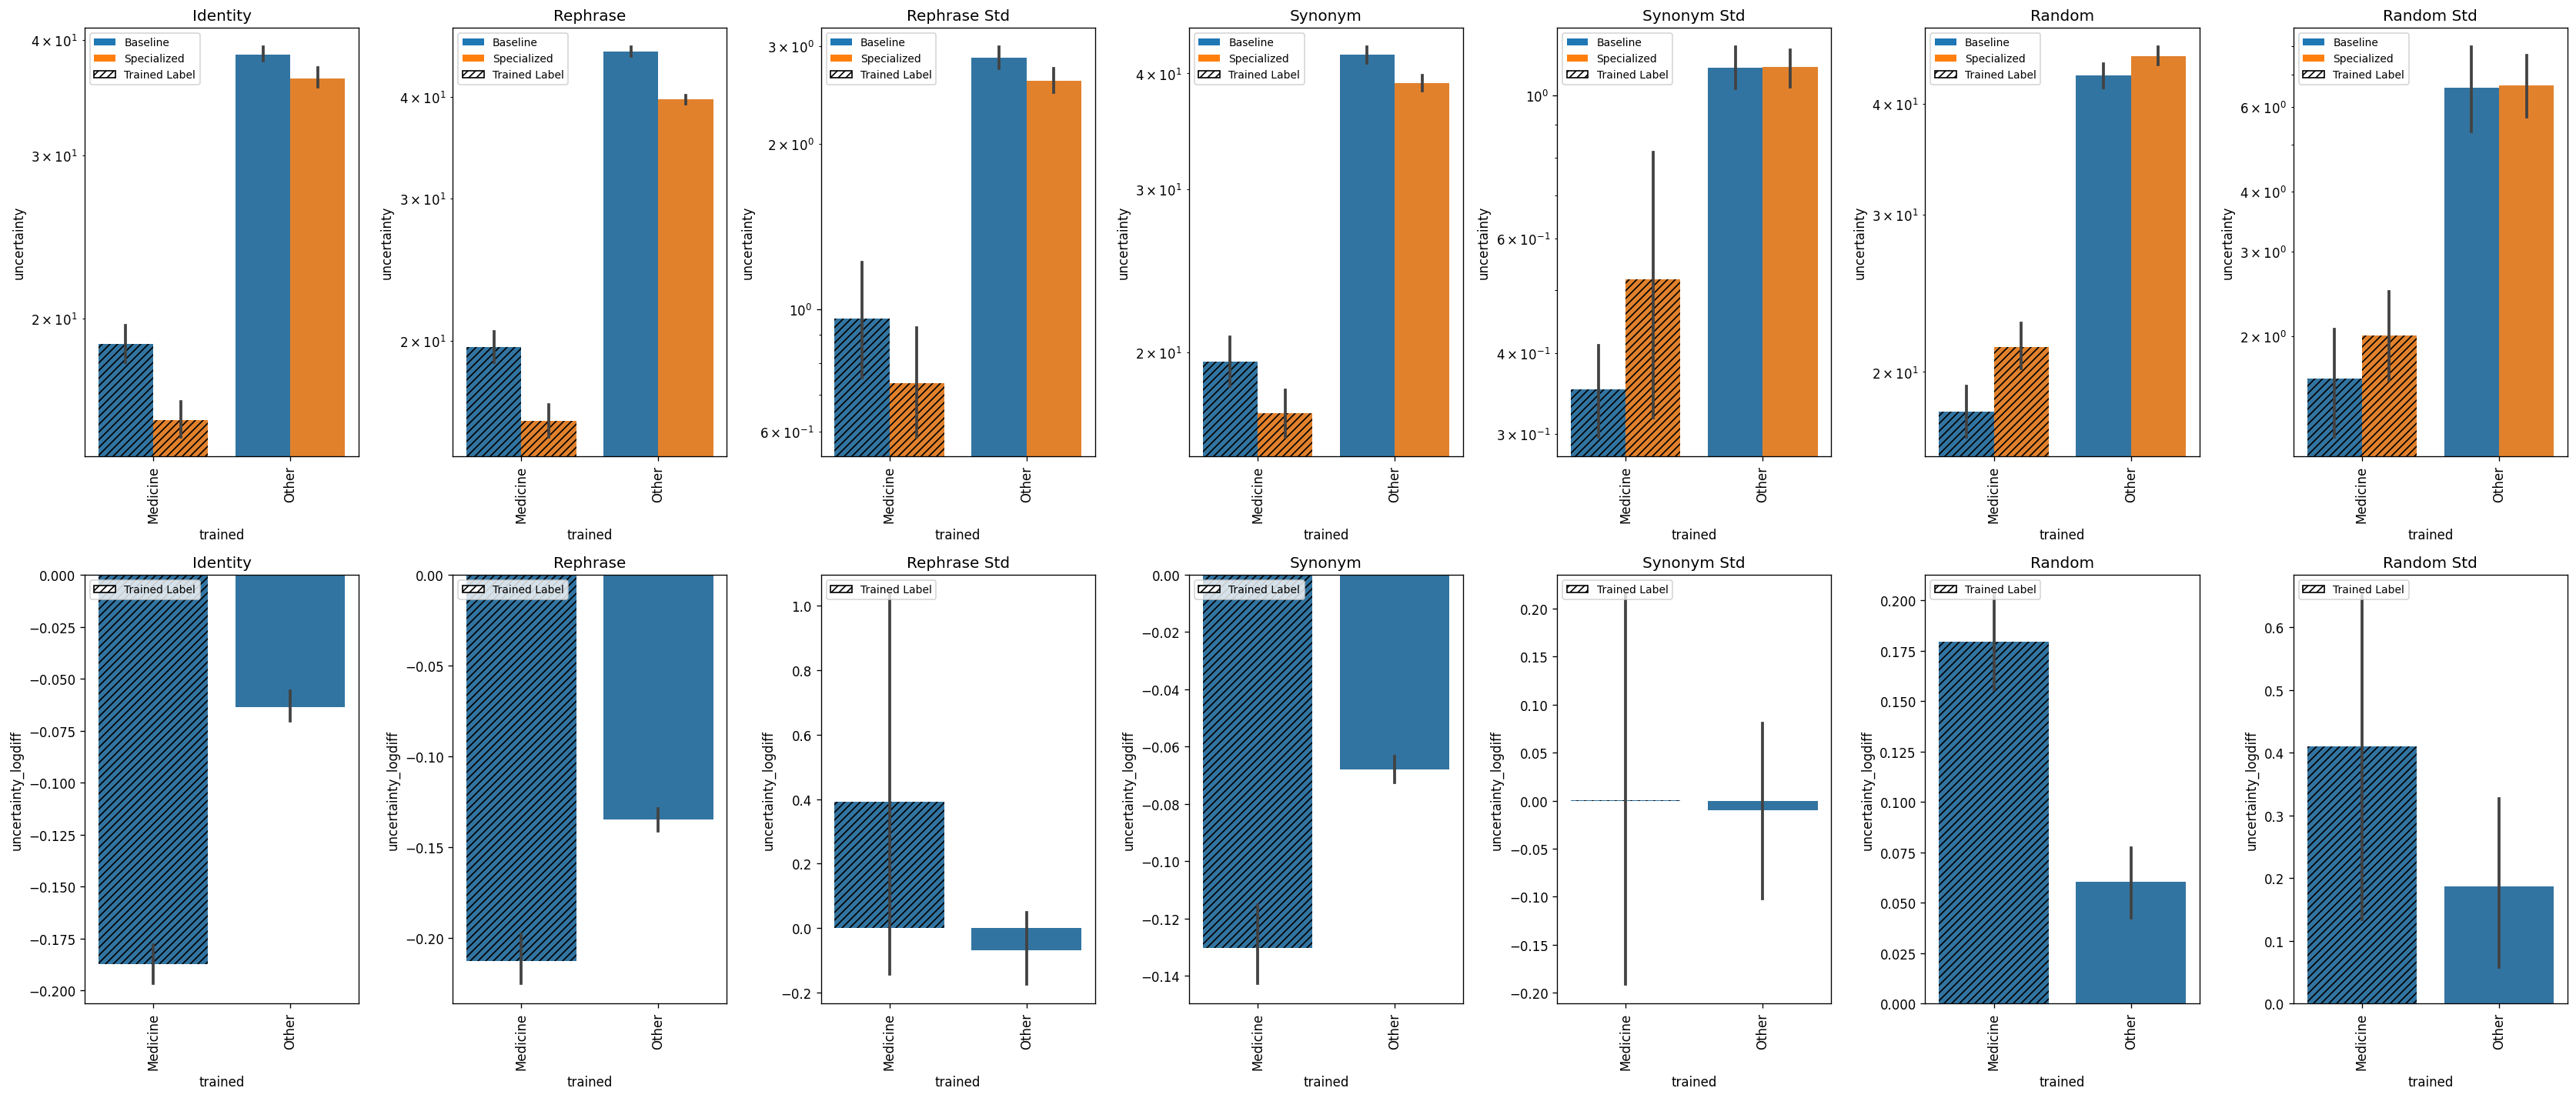

In [32]:
plot(dfs, "trained", experiment, dataset)

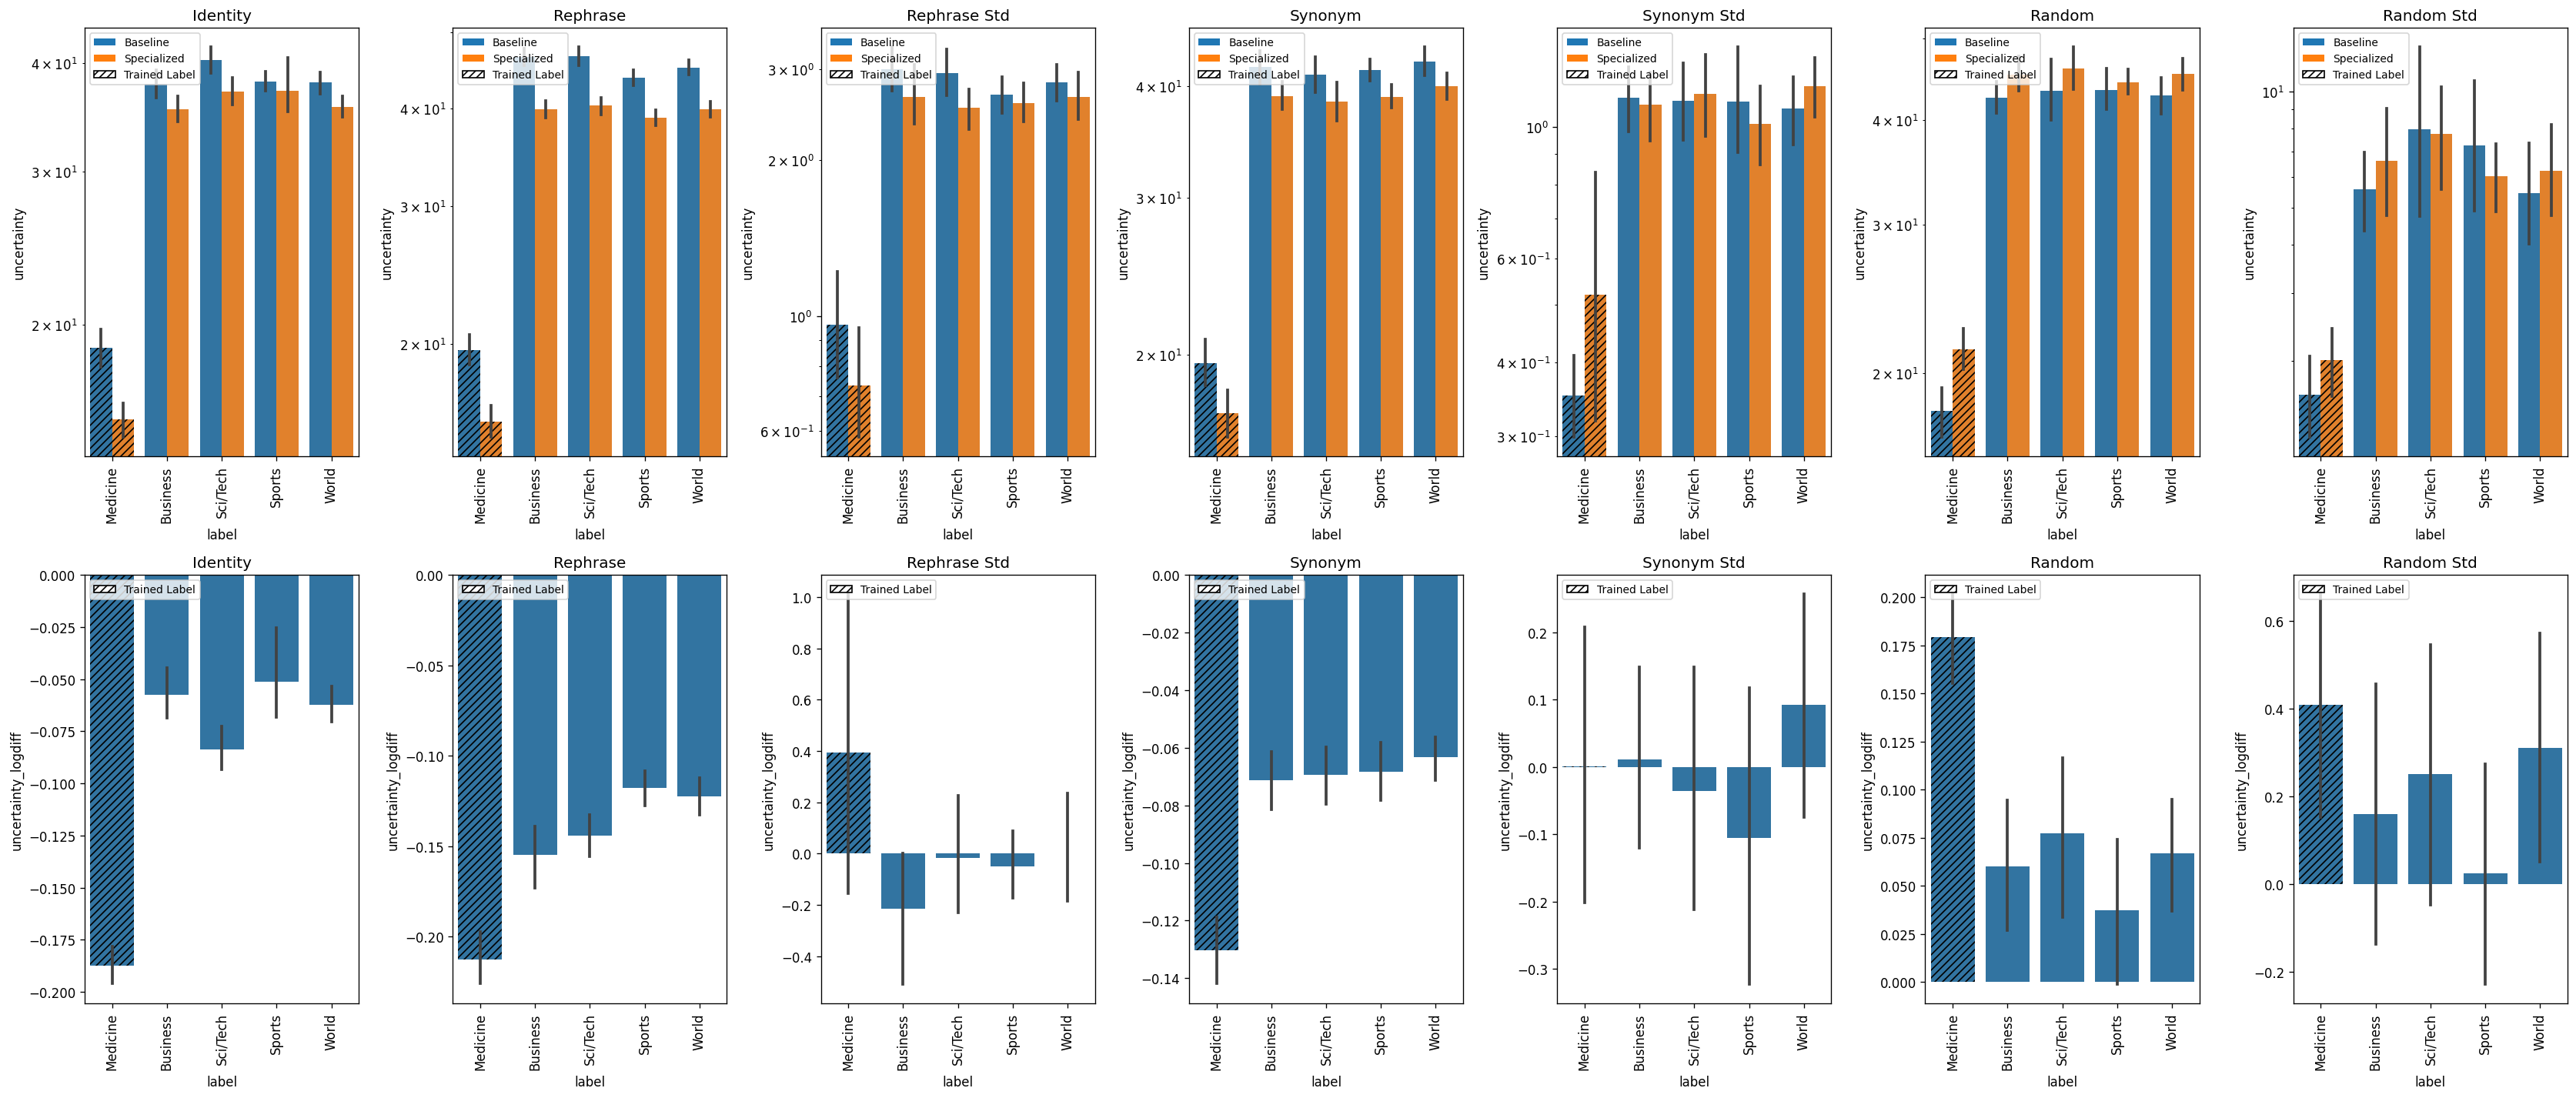

In [33]:
plot(dfs, "label", experiment, dataset)

/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_8634/3153389452.py:184: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_8634/3153389452.py:184: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_8634/3153389452.py:184: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_8634/3153389452.py:184: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_8634/3153389452.py:184: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_8634/3153389452.py:184: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_8634/

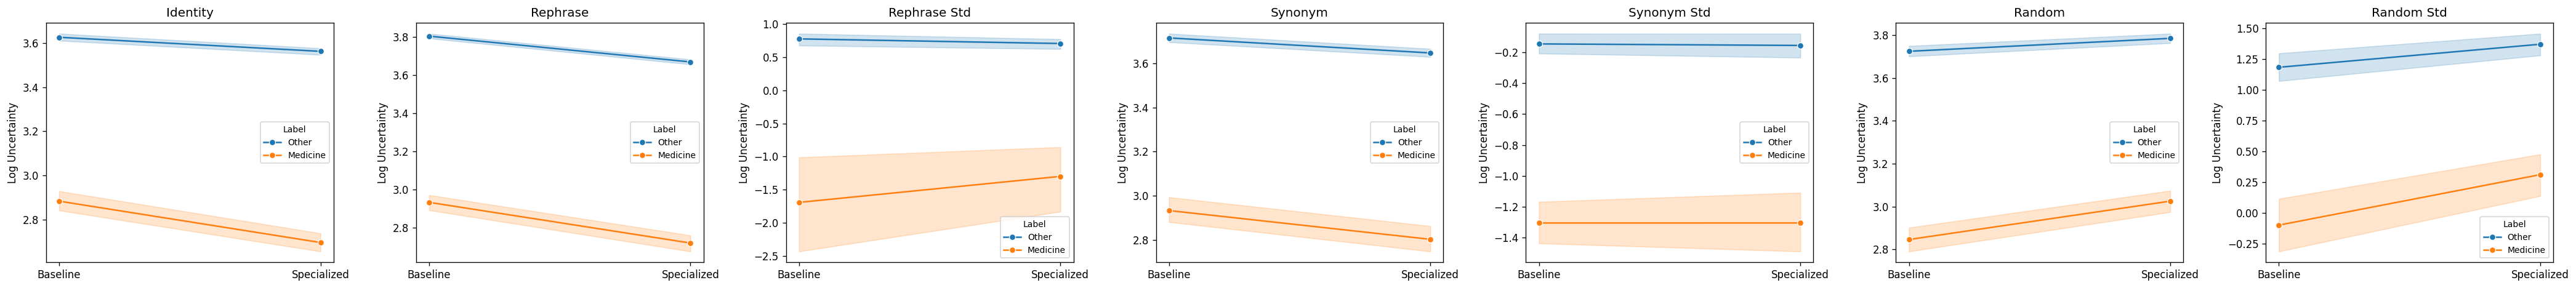

In [34]:
plot_log_did(dfs, experiment, dataset)

In [35]:
t_tests(dfs, "uncertainty_logdiff")

Identity   Medicine vs Others T-statistic:     -21.0768, P-value: 0.0000
Rephrase   Medicine vs Others T-statistic:     -10.0606, P-value: 0.0000
Rephrase Std Medicine vs Others T-statistic:       1.4932, P-value: 0.1369
Synonym    Medicine vs Others T-statistic:      -8.9724, P-value: 0.0000
Synonym Std Medicine vs Others T-statistic:       0.0887, P-value: 0.9295
Random     Medicine vs Others T-statistic:       7.9710, P-value: 0.0000
Random Std Medicine vs Others T-statistic:       1.4940, P-value: 0.1372

Identity   Medicine vs World      T-statistic:     -19.6713, P-value: 0.0000
Identity   Medicine vs Sports     T-statistic:     -11.2275, P-value: 0.0000
Identity   Medicine vs Business   T-statistic:     -16.8004, P-value: 0.0000
Identity   Medicine vs Sci/Tech   T-statistic:     -14.3762, P-value: 0.0000
Rephrase   Medicine vs World      T-statistic:     -10.4022, P-value: 0.0000
Rephrase   Medicine vs Sports     T-statistic:     -11.0447, P-value: 0.0000
Rephrase   Medicine vs 

In [36]:
compute_log_diff_in_diff(dfs)

Identity   Medicine log-DiD effect:    -0.1236, SE:   0.0278, P-value: 0.0000
Rephrase   Medicine log-DiD effect:    -0.0779, SE:   0.0234, P-value: 0.0009
Rephrase Std Medicine log-DiD effect:     0.4625, SE:   0.2489, P-value: 0.0633
Synonym    Medicine log-DiD effect:    -0.0623, SE:   0.0338, P-value: 0.0653
Synonym Std Medicine log-DiD effect:     0.0103, SE:   0.1213, P-value: 0.9324
Random     Medicine log-DiD effect:     0.1189, SE:   0.0397, P-value: 0.0028
Random Std Medicine log-DiD effect:     0.2225, SE:   0.1634, P-value: 0.1736
